In [ ]:
# data preprocessing ipynb file

# %run "/content/drive/MyDrive/Colab Notebooks/cancer_data_preprocessing.ipynb"

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
folder = "/content/drive/MyDrive/Colab Notebooks/DATASET/cancer/"

# Read labeled balanced dataset
train_bal_sel = pd.read_csv(folder + "train_bal_sel.csv")

# Read unlabeled selected dataset
train_unl_sel = pd.read_csv(folder + "train_unl_sel.csv")

# Read test set with selected features
test_sel= pd.read_csv(folder + "X_test_sel.csv")

print(train_bal_sel.shape)
print(train_unl_sel.shape)
print(test_sel.shape)

(280, 1001)
(250, 1000)
(401, 1000)


In [13]:
# Splitting the labeled dataframe into X and y
X_train_lab = train_bal_sel.drop(columns=["Class"])
y_train_lab = train_bal_sel["Class"]

print(X_train_lab.shape)
print(y_train_lab.shape)

(280, 1000)
(280,)


Using XGBclassifier to train the labelled data.

*   Using GridSearchCV with custom parameter grid with 5 fold cross-validation to find the best model prameters



In [14]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, precision_score, recall_score

# Define parameter grid for tuning
param_grid = {
    'n_estimators': [300, 500, 800, 1200],
    'max_depth': [5, 7],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'gamma': [0]
}

# Initialize XGBoost Classifier
xgb = XGBClassifier(
    objective='multi:softprob',
    num_class=5,
    eval_metric='mlogloss',
    random_state=42
)

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV (
    estimator=xgb,
    param_grid=param_grid,
    scoring='neg_log_loss',
    cv=5,
    verbose=2,
    n_jobs=-1
)

# Fit on labeled training data
grid_search.fit(X_train_lab, y_train_lab)

# Best Parameters and Score
print("Best Parameters:", grid_search.best_params_)
print("Best CV log loss: {:.4f}".format(grid_search.best_score_))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 1200, 'subsample': 0.8}
Best CV log loss: -0.0582


In [15]:
# saving the best model
best_model = grid_search.best_estimator_
print("Best Model:\n", best_model)

Best Model:
 XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1200,
              n_jobs=None, num_class=5, num_parallel_tree=None, ...)


SEMI-SUPERVISED
* Using the best model we are predicting the class label for the unlabeled
dataframe
* Thus creating pseudo label for unlabeled dataset

In [16]:
# Predict on unlabeled data (for semi-supervised)
unlabeled_probs = best_model.predict_proba(train_unl_sel)
# pseudo label
unlabeled_preds = np.argmax(unlabeled_probs, axis=1)

Combined the labled and unlabeled dataset
* created X_all (labeled + unlabeled) features
* created y_all (class from labeled data + pseudo label from unlabeled data)

# FINAL MODEL TRAINING

In [1]:
# Combine labeled + pseudo-labeled
X_all = np.vstack([X_train_lab, train_unl_sel])
y_all = np.hstack([y_train_lab, unlabeled_preds])

# Training the final model using the best model parameters
final_model = XGBClassifier(
    **grid_search.best_params_,
    objective='multi:softprob',
    num_class=5,
    eval_metric='mlogloss',
    random_state=42,
)

# Fit on combined data
final_model.fit(X_all, y_all)

NameError: name 'np' is not defined

# Predition on test data

In [22]:
# Predict on test set
test_probs = final_model.predict_proba(test_sel)
# Prediction on test data saved as test_preds
test_preds = np.argmax(test_probs, axis=1)

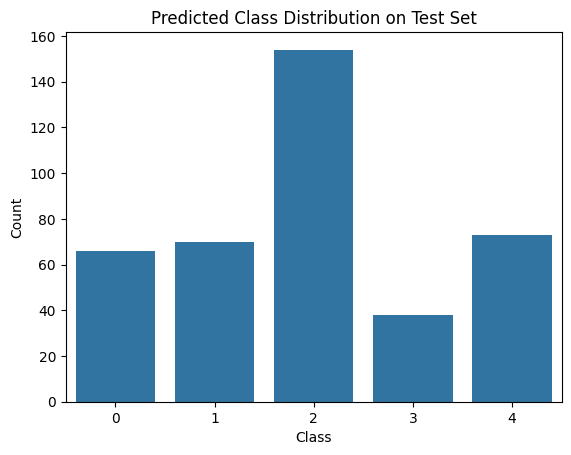

In [23]:
# Predicted class distribution
sns.countplot(x=test_preds)
plt.title("Predicted Class Distribution on Test Set")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

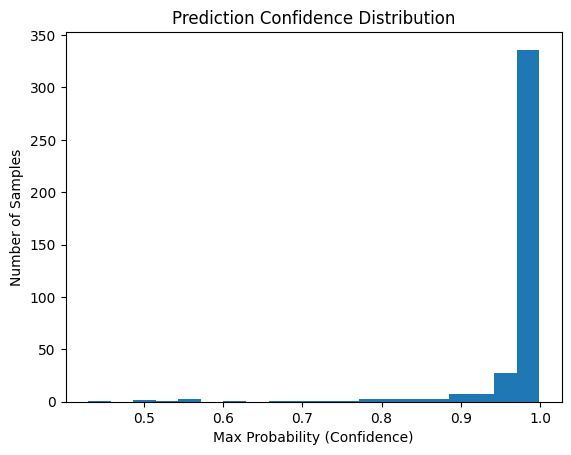

In [24]:
# Predicted class probabilities
# Histogram of confidence per prediction
max_confidences = np.max(test_probs, axis=1)
plt.hist(max_confidences, bins=20)
plt.title("Prediction Confidence Distribution")
plt.xlabel("Max Probability (Confidence)")
plt.ylabel("Number of Samples")
plt.show()

In [25]:
# Extracting the Id from original test data

original_test = pd.read_csv(folder + "test.csv")
test_id = original_test["Id"]

In [26]:
# Saving the predition in CSV

submission = pd.DataFrame({
    'Id': test_id,
    'Class': test_preds
})

# Save to Google Drive with your desired filename
submission.to_csv(folder + "result_on_selected_test.csv", index=False)
print("Saved as 'result_on_selected_test.csv' in Google Drive")


Saved as 'result_on_selected_test.csv' in Google Drive
